#  Notebook to visualize K3 gain files
- modified 27.02.1024

In [1]:
# import modules

import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs


In [2]:
# define files name. Dm4  was orginal and mrc was made using imod dm2mrc
fnMrcGain = 'K3-18210046_GainRef.x1.m1.kv300.mrc'
fnDmGain =  'K3-18210046_GainRef.x1.m1.kv300.dm4'

In [3]:
# load the files 
MrcGain = mrcfile.open(fnMrcGain, mode='r+')
DmGain = hs.load(fnDmGain) 
# these files are super-resolution arrording to shape
print(MrcGain.data.shape)
print(DmGain.data.shape)

print(MrcGain.data.dtype)
print(DmGain.data.dtype)

print(np.min(MrcGain.data), np.max(MrcGain.data) )
print(np.min(DmGain.data), np.max(DmGain.data) )

(8184, 11520)
(8184, 11520)
float32
float32
0.5000515 1.9955579
0.5000515 1.9955579


Text(0.5, 1.0, 'MRC (dm2mrc - on mac)')

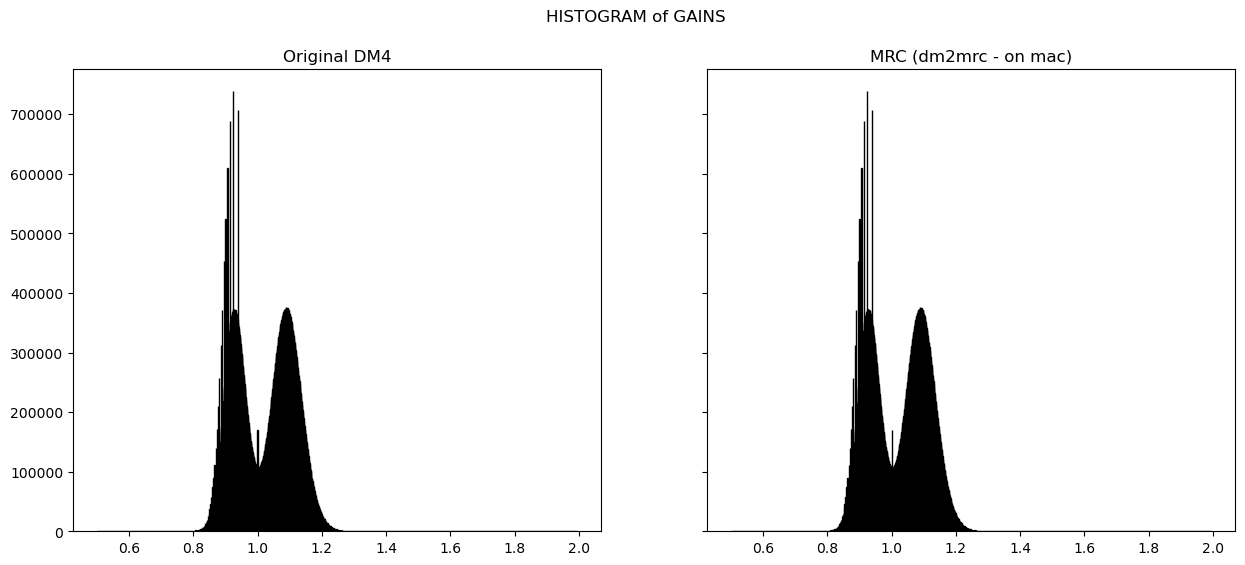

In [4]:
# plot histogram of pixel values
# why is there a bimodal distribution? it is a wrap around effect resulting from lack of precision in numpy float32
# what are the sharp peaks < 1
# note he the peak = 1: if I look at the defect file the pixle it indicates are deffective (value =251) the same pixels in the gain have a 
# value exactly = 1.. I think in the gain the defective pixels are set to 1.

fig, axs = plt.subplots(ncols=2,nrows=1,sharex=True, sharey=True,figsize=(15,6))
fig.suptitle('HISTOGRAM of GAINS')
axs[0].hist(DmGain.data.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('Original DM4')
axs[1].hist(MrcGain.data.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('MRC (dm2mrc - on mac)')

In [5]:
# look at corner of array
# 1.0 seems to mark the defective pixels
# the first pixel (0:2,0:2) are all 1 = All super res pixels are morked defective
# in pixel in next row (2:4,2:4) some are defect and some not, why?
DmGain.data[0:4,0:4]

array([[1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.66432834, 0.8397214 , 1.4344461 ],
       [1.        , 0.66193867, 0.75772506, 1.3320917 ]], dtype=float32)

In [6]:
def rebin(im, f, funcType='sum'):
    """ Rebin a 2D array. From stackoverflow:
    https://stackoverflow.com/questions/4624112/grouping-2d-numpy-array-in-average
    https://github.com/ercius/openNCEM/blob/f3b284069bedf94107ac31ef3c23bcda684e4b5d/ncempy/algo/__init__.py#L8

    Parameters
    ----------
    im : ndarray
        2D array to reduce
    f : int
        The factor to rebin by. Must be integer
    funcType : str
        The type of reduction. mean or sum are implemented.

    Returns
    -------
    : ndarray
        The 2D array with the new size.
    """

    nbig = im.shape
    nsmall = [ii // f for ii in im.shape]

    # Reshape the array so that the required neighborhood are in arrays along certain axes
    # Then average or sum those neighborhoods
    im_reshape = im.reshape([nsmall[0], nbig[0] // nsmall[0], nsmall[1], nbig[1] // nsmall[1]])
    # Reduce using different types of functions
    if funcType == 'mean':
        small = im_reshape.mean(3).mean(1)
    elif funcType == 'sum':
        small = im_reshape.sum(3).sum(1)
    # elif funcType == 'median':
    #    small = im_reshape.median(3).median(1)
    else:
        print('defaulting to sum')
        small = im_reshape.sum(3).sum(1)

    return small

In [7]:
print(f'Size before binning: {DmGain.data.shape}')
DmGainBin = rebin(DmGain.data, 2, funcType='mean')
print(f'Size after binning:  {DmGainBin.shape}')


Size before binning: (8184, 11520)
Size after binning:  (4092, 5760)


In [ ]:
# why does binning make the bimodal distibution disappear. It seems to me that the 4 super-res pixels have 2 pixel from the 
# from the low peak and 2 from the high. Why?
# fc = facecolor fc='k'
# ec  = edgecolor ec='k'

fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(15,6))
fig.suptitle('HISTOGRAM of GAINS Before and after binning')
axs[0].hist(DmGain.data.ravel(), bins='auto')
axs[0].set_title('Original')
axs[1].hist(DmGainBin.ravel(), bins='auto')
axs[1].set_title('Binned')